#Задача:
Взять любую видеопоследовательность (желательно вид сверху) - например полет дрона. Можете скачать из  интернета или взять что то с работы. 
Зафиксировав точку (например центр экрана) выполнить стабилизацию данной точки с использованием матрицы афинного преобразования 
(считая матрицу между кадрами вы всегда сможете понять где именно находится точка на изображении, а по отклонению самой точки вы можете определить точность самого алгоритма).
Не берите 4к - долго считать, HD будет достаточно
Посчитать расстояние между точками и ошибку в пикселях.
Попробуйте добавить шум к изображению, посмотрите как меняется точность (положение точки). 
Добавьте фильтр к изображению для улучшения контрастности (любой который найдете).
Оцените как влияет выбор метода определения матрицы афинного преобразования - например estimateAffine2D и его аналоги (аналоги найдите самии).
Оцените как влияет выбор детектора/дескриптора особых точек на результат. Какой метод даст лучший и самый быстрый результат? 

In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
def extract_features(image, detector='sift', mask=None):

    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [3]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [4]:
def filter_matches_distance(matches, dist_threshold):
    
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [5]:
def estimate_partial_transform(cur_matched_kp, prev_matched_kp ,method):
    
    transform = cv2.estimateAffine2D(np.array(prev_matched_kp),
                                           np.array(cur_matched_kp),method=method)[0] 
                                                                                         
    #print(transform)    
    if transform is not None:
        # translation x
        dx = transform[0, 2]
        # translation y
        dy = transform[1, 2]
        # rotation
        da = np.arctan2(transform[1, 0], transform[0, 0])
    else:
        dx = dy = da = 0

    return [dx, dy, da], transform

In [6]:
def decompose_affine_matrix(affine):

    if affine.shape != (3, 3) or affine.dtype != np.float64:
        raise ValueError("Invalid input matrix. Must be a 3x3 double matrix.")

    R = affine[:2, :2]
    U, W, Vt = np.linalg.svd(R)

    rotation = np.dot(U, Vt)
    scaling = np.diag(W)
    translation = affine[:2, 2:]

    return rotation, translation, scaling

In [7]:
def recompose_affine_matrix(rotation, translation, scaling):
    
    # Combine rotation and scaling
    rotation_scaling = np.dot(rotation, scaling)
    
    # Create the 3x3 affine matrix
    affine = np.eye(3)
    affine[:2, :2] = rotation_scaling
    affine[:2, 2] = translation.flatten()
    
    return affine

In [36]:

cap = cv2.VideoCapture('video.mp4')

def nothing(x):
    pass

cv2.namedWindow('settings')
cv2.createTrackbar('k', 'settings', 10, 100, nothing)
switch = '0 : OFF\n 1 : ON'
cv2.createTrackbar("On/Off", 'settings', 0, 1, nothing)

ret_old, frame_old = cap.read()
k = 0.2
x = 300
y = 50
i = 0
while True:

    ret, frame = cap.read()
    if not ret:
        break
    
    blurred = cv2.GaussianBlur(frame, (11,11),0)
    frame = cv2.addWeighted(frame, 2, blurred, -1, 0)    
    
      
    kp0, des0 = extract_features(frame, 'sift')
    kp1, des1 = extract_features(frame_old, 'sift')
    
    matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
    
     
     
    
    s = cv2.getTrackbarPos("On/Off", 'settings')
    if s == 0:
     pass
    else:
        k = cv2.getTrackbarPos('k', 'settings')/100
        
    
      
    
    matches = filter_matches_distance(matches, 0.5)
    
    src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)    
    m , M = estimate_partial_transform(src_pts,dst_pts, cv2.LMEDS)
    afine_transform_matrix =  np.append(M,np.array([0,0,1])).reshape(3,3)
    
     
    frame_old = frame.copy()
    
    x_hom = np.array([x, y, 1])
    x_hom_new = np.dot(afine_transform_matrix, x_hom)
    x = x_hom_new[0]
    y = x_hom_new[1]
      
            
    frame = cv2.circle(frame, (int(x), int(y)), 5, (0, 0, 255), -1)    
    if i == 1 or i == 2670:
        cv2.imwrite(f'frame_{i}.jpg', frame)
    cv2.imshow('frame', frame)
    
    i+=1
    
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


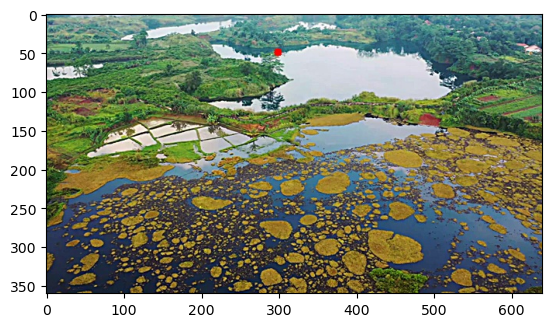

In [38]:
input_img0 = cv2.imread("frame_1.jpg")
img0 = cv2.cvtColor(input_img0,cv2.COLOR_BGR2RGB)
input_img1 = cv2.imread("frame_2670.jpg")
img1 = cv2.cvtColor(input_img1,cv2.COLOR_BGR2RGB)
plt.imshow(img0)

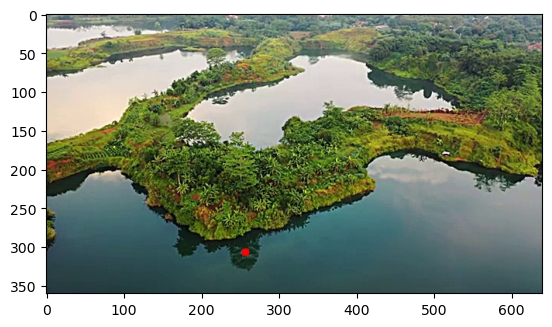

In [39]:
plt.imshow(img1)

In [9]:
cap = cv2.VideoCapture('video.mp4')

def nothing(x):
    pass

cv2.namedWindow('settings')
cv2.createTrackbar('k', 'settings', 10, 100, nothing)
switch = '0 : OFF\n 1 : ON'
cv2.createTrackbar("On/Off", 'settings', 0, 1, nothing)

ret_old, frame_old = cap.read()
k = 0.2
x = 300
y = 50
i = 0
while True:

    ret, frame = cap.read()
    if not ret:
        break
    
    
    
     #Фильтр контрастности
    frame = cv2.bilateralFilter(frame, 15, 75, 75)  
    
    kp0, des0 = extract_features(frame, 'orb')
    kp1, des1 = extract_features(frame_old, 'orb')
    
    matches = match_features(des0, des1, matching='BF', detector='orb', sort=True)
    
     
     
    
    s = cv2.getTrackbarPos("On/Off", 'settings')
    if s == 0:
     pass
    else:
        k = cv2.getTrackbarPos('k', 'settings')/100
        
    
      
    
    matches = filter_matches_distance(matches, 0.2)
    
    src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)    
    m , M = estimate_partial_transform(src_pts,dst_pts, cv2.LMEDS)
    afine_transform_matrix =  np.append(M,np.array([0,0,1])).reshape(3,3)
    
     
    frame_old = frame.copy()
    
    x_hom = np.array([x, y, 1])
    x_hom_new = np.dot(afine_transform_matrix, x_hom)
    x = x_hom_new[0]
    y = x_hom_new[1]
      
            
    frame = cv2.circle(frame, (int(x), int(y)), 5, (0, 0, 255), -1)    
    if i == 2670:
        cv2.imwrite(f'frame_orb_{i}.jpg', frame)
    cv2.imshow('frame', frame)
    
    i+=1
    
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

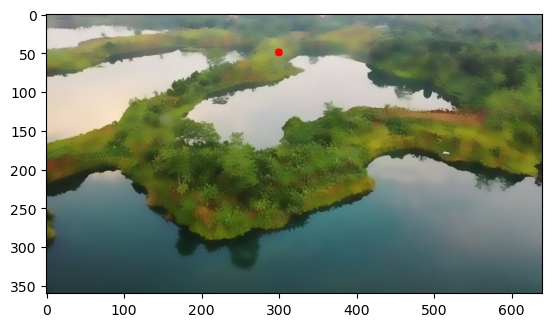

In [10]:
input_orb = cv2.imread("frame_orb_2670.jpg")
img_orb = cv2.cvtColor(input_orb,cv2.COLOR_BGR2RGB)
plt.imshow(img_orb)

#Вывод:
С помощью sift удалось добиться достаточно точного позиционирования, но время обработки было достаточно долним. 
Оптический поток в данном случае не дал необходимого результата. Добавление фильтра контрастности никак не помогло.